In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

simplefilter(action='ignore', category=RuntimeWarning)
simplefilter(action='ignore', category=FutureWarning)

In [2]:
forcing_list = ['historical','hist-aer','hist-GHG','hist-nat']
name_list    = ['prec','scaling','scaling_thermo','scaling_dynamic']
model_path   = {'historical':'historical','hist-aer':'aer','hist-GHG':'GHG','hist-nat':'nat'}
var_name     = var_name
ax_locs      = {'historical':{'prec':0,'scaling_thermo':1,'scaling_dynamic':2},
                'hist-GHG':{'prec':3,'scaling_thermo':4,'scaling_dynamic':5},
                'hist-aer':{'prec':6,'scaling_thermo':7,'scaling_dynamic':8},
                'hist-nat':{'prec':9,'scaling_thermo':10,'scaling_dynamic':11},    
               }

In [3]:
def _scaling_rate(temp,var):
    var_ln = np.log(var)
    fit   = linregress(temp,var_ln)
    slp   = fit.slope
    sr    = (np.exp(slp)-1)*100
    return sr 

def scaling_rate_cal_global_warming(tas,var):  ### use global surface temperature
    tas = xr.DataArray(data=tas['gst'],dims=['time'],name='global_surface_temperature',coords=dict(time=tas.index))
    scaling_rate = xr.apply_ufunc(_scaling_rate,
                                  tas,
                                  var,
                                  vectorize=True,
                                  dask='parallelized', 
                                  input_core_dims=[['time'],['time']],
                                  output_dtypes=[float],
                                  )
    return scaling_rate

def scaling_rate_cal_local_warming(tas,var):  ### use local temperature conditioned on Rx1day occur
    scaling_rate = xr.apply_ufunc(_scaling_rate,
                                  tas,
                                  var,
                                  vectorize=True,
                                  dask='parallelized', 
                                  input_core_dims=[['time'],['time']],
                                  output_dtypes=[float],
                                  )
    return scaling_rate

def reshape(data):
    value1 = data.values
    value2 = np.concatenate((value1[:,:,[-1]],value1[:,:,:-1]),axis=2)
    value3 = np.concatenate((value1[:,:,1:],value1[:,:,[0]]),axis=2)
    value4 = np.concatenate((value1[:,[0],:],value1[:,:-1,:]),axis=1)
    value5 = np.concatenate((value1[:,1:,:],value1[:,[-1],:]),axis=1)
    value6 = np.concatenate((value3[:,[0],:],value3[:,:-1,:]),axis=1)
    value7 = np.concatenate((value3[:,1:,:],value3[:,[-1],:]),axis=1)
    value8 = np.concatenate((value2[:,[0],:],value2[:,:-1,:]),axis=1)
    value9 = np.concatenate((value2[:,1:,:],value2[:,[-1],:]),axis=1)
    value = (value1 + value2 + value3 + value4 + value5 + value6 + value7 + value8 + value9) / 9
    data.values = value
    return data


## calculate changes in Rx1day and its terms with respect to global warming

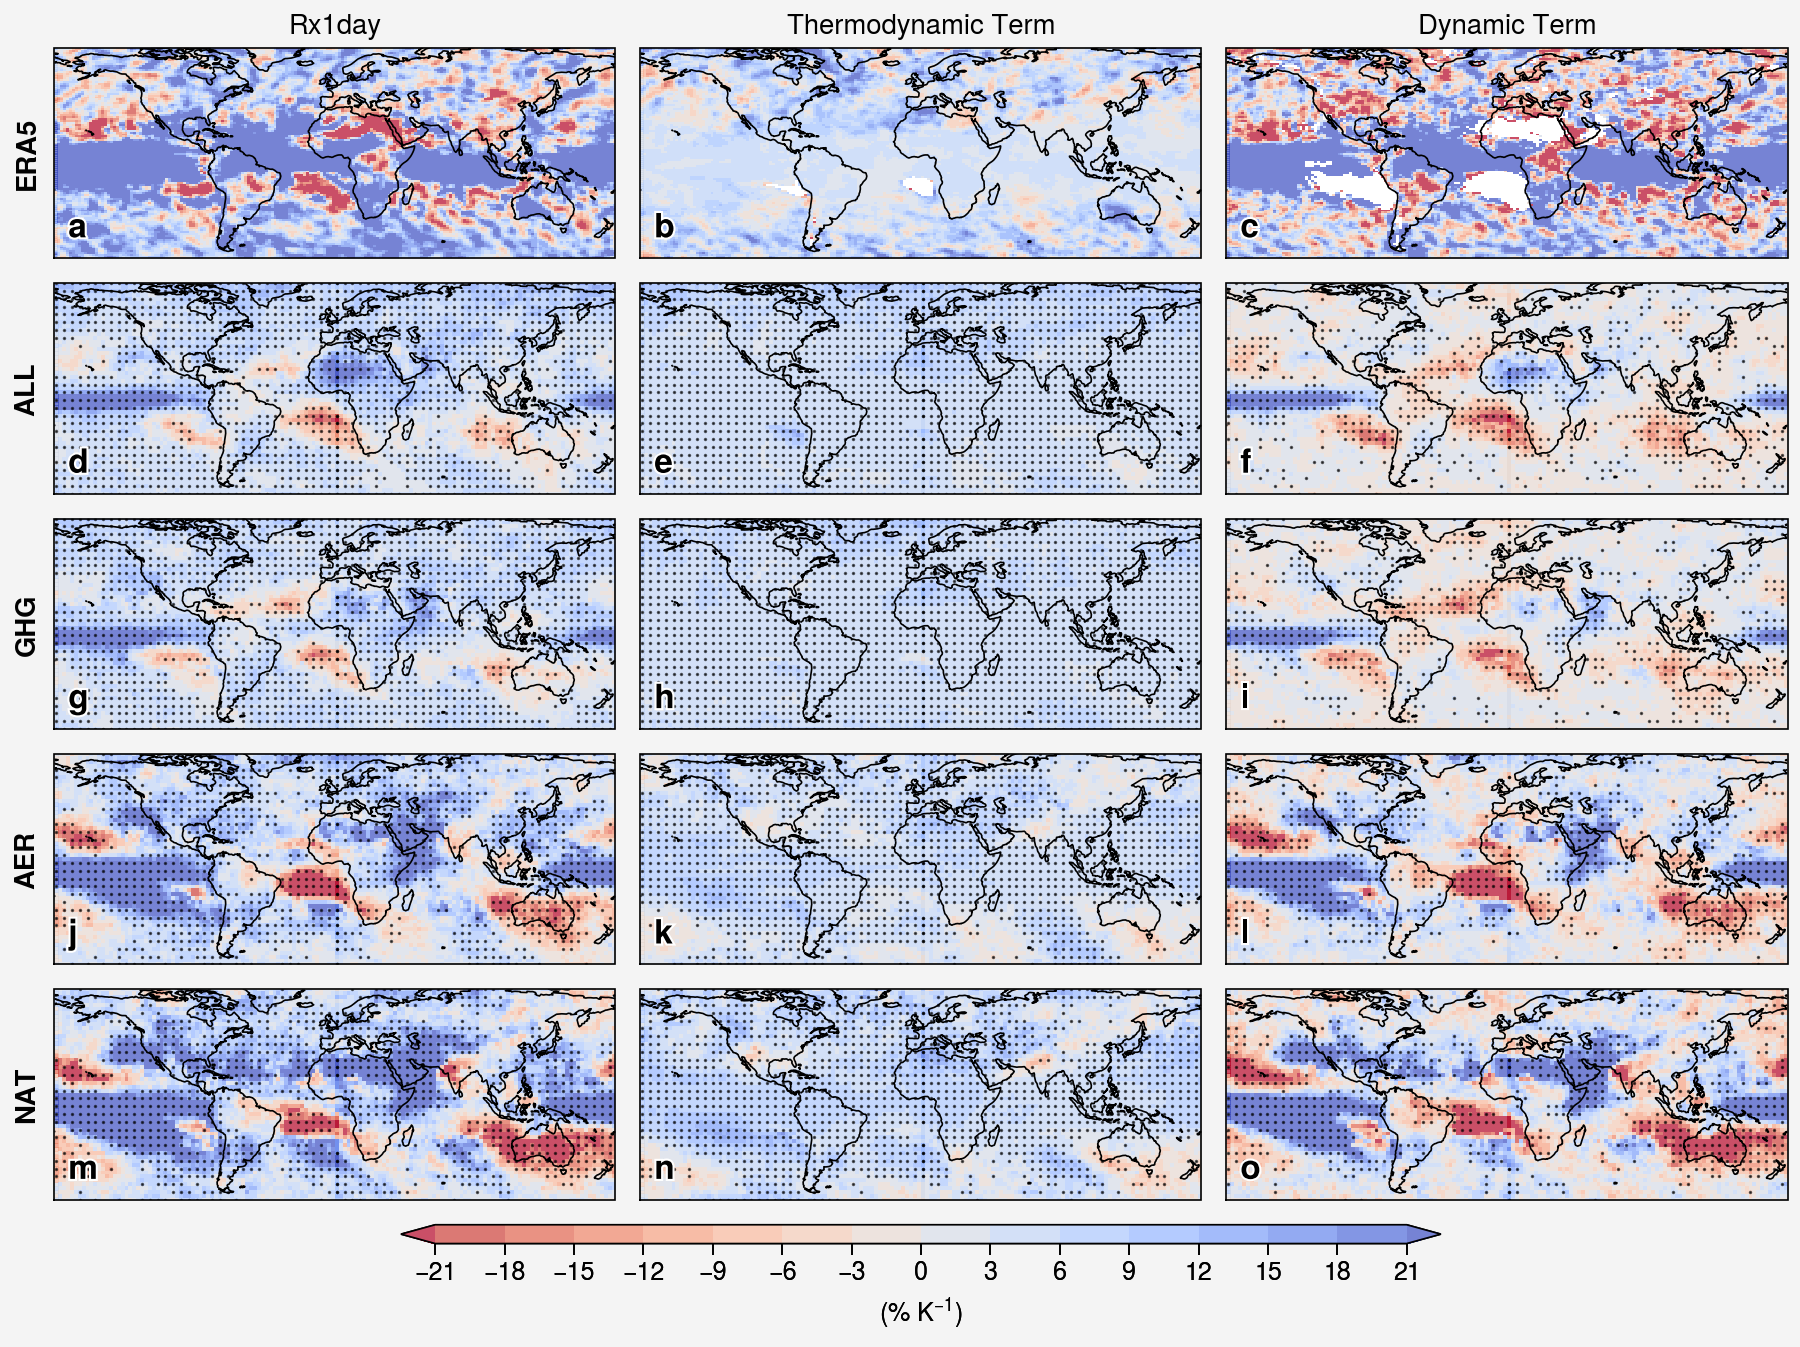

In [5]:
# fig, axs = pplot.subplots(ncols=3,nrows=5,span=False,wspace=(0.05,0.05),hspace=(0.05,0.05,0.05,0.05),proj='pcarree',width=10)
fig, axs = pplot.subplots(ncols=3,nrows=5,wratios=(1,1,1),wspace=1,hspace=1,share=False,
                        proj='pcarree',width=9)
                        
axs.format(
    grid=False,
    leftlabels=('ERA5','ALL', 'GHG', 'AER', 'NAT'),
)

forcing_list = ['ERA5','historical','hist-aer','hist-GHG','hist-nat']
era5_gst = pd.read_csv('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_res/era5/era5_global_mean_surf_temp.csv',header=0,index_col=0)
jra55_gst = pd.read_csv('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_res/jra55/jra55_global_mean_surf_temp.csv',header=0,index_col=0)
ncep2_gst = pd.read_csv('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_res/ncep2/ncep2_global_mean_surf_temp.csv',header=0,index_col=0)

ax_locs      = {
                'ERA5':{'prec':0,'scaling_thermo':1,'scaling_dynamic':2},
                'historical':{'prec':3,'scaling_thermo':4,'scaling_dynamic':5},
                'hist-GHG':{'prec':6,'scaling_thermo':7,'scaling_dynamic':8},
                'hist-aer':{'prec':9,'scaling_thermo':10,'scaling_dynamic':11},
                'hist-nat':{'prec':12,'scaling_thermo':13,'scaling_dynamic':14},    
               }

# cmap=cmaps.BlueDarkRed18_r
cmap=cmaps.MPL_coolwarm_r
levels = MaxNLocator(nbins=15).tick_values(-21, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

for f in forcing_list:
    forcing  = f
    if forcing == 'ERA5':
        src_id = 'era5'
        run = 'reanalysis'
        file_prec = glob.glob(forcing_dir['era5'] + 'prec' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        era5_prec = xr.open_dataarray(file_prec)
        era5_prec = era5_prec.sel(time=slice('1960','2014'))
        era5_prec['time'] = range(1960,2015)
        era5_prec = era5_prec.rename({'longitude':'lon','latitude':'lat'})
        era5_prec = era5_prec.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        era5_prec[:,:,-1] = (era5_prec[:,:,-2] + era5_prec[:,:,0]) / 2
        era5_prec = reshape(era5_prec)
        era5_prec_rate = scaling_rate_cal_global_warming(tas = era5_gst.loc[1960:2014], var = era5_prec)

        file_scaling = glob.glob(forcing_dir['era5'] + 'scaling' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        era5_scaling = xr.open_dataarray(file_scaling)
        era5_scaling = era5_scaling.sel(time=slice('1960','2014'))
        era5_scaling['time'] = range(1960,2015)
        era5_scaling = era5_scaling.rename({'longitude':'lon','latitude':'lat'})
        era5_scaling = era5_scaling.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        era5_scaling[:,:,-1] = (era5_scaling[:,:,-2] + era5_scaling[:,:,0]) / 2
        era5_scaling = reshape(era5_scaling)

        file_scaling_thermo = glob.glob(forcing_dir['era5'] + 'scaling_thermo' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        era5_scaling_thermo = xr.open_dataarray(file_scaling_thermo)
        era5_scaling_thermo = era5_scaling_thermo.sel(time=slice('1960','2014'))
        era5_scaling_thermo['time'] = range(1960,2015)
        era5_scaling_thermo = era5_scaling_thermo.rename({'longitude':'lon','latitude':'lat'})
        era5_scaling_thermo = era5_scaling_thermo.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        era5_scaling_thermo[:,:,-1] = (era5_scaling_thermo[:,:,-2] + era5_scaling_thermo[:,:,0]) / 2
        era5_scaling_thermo = reshape(era5_scaling_thermo)
        era5_scaling_thermo = era5_scaling_thermo + era5_scaling.mean(axis=0)
        era5_scaling_thermo_rate = scaling_rate_cal_global_warming(tas = era5_gst.loc[1960:2014], var = era5_scaling_thermo)

        file_scaling_dynamic = glob.glob(forcing_dir['era5'] + 'scaling_dynamic' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        era5_scaling_dynamic = xr.open_dataarray(file_scaling_dynamic)
        era5_scaling_dynamic = era5_scaling_dynamic.sel(time=slice('1960','2014'))
        era5_scaling_dynamic['time'] = range(1960,2015)
        era5_scaling_dynamic = era5_scaling_dynamic.rename({'longitude':'lon','latitude':'lat'})
        era5_scaling_dynamic = era5_scaling_dynamic.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        era5_scaling_dynamic[:,:,-1] = (era5_scaling_dynamic[:,:,-2] + era5_scaling_dynamic[:,:,0]) / 2
        era5_scaling_dynamic = reshape(era5_scaling_dynamic)
        era5_scaling_dynamic = era5_scaling_dynamic + era5_scaling.mean(axis=0)
        era5_scaling_dynamic_rate = scaling_rate_cal_global_warming(tas = era5_gst.loc[1960:2014], var = era5_scaling_dynamic)

        lats1d = era5_prec_rate['lat']
        lons1d = era5_prec_rate['lon']
        axs[0].pcolormesh(lons1d,lats1d,era5_prec_rate, cmap=cmap, norm=norm,label=False,extend='both',alpha=0.7)
        axs[1].pcolormesh(lons1d,lats1d,era5_scaling_thermo_rate, cmap=cmap, norm=norm,label=False,extend='both',alpha=0.7)
        axs[2].pcolormesh(lons1d,lats1d,era5_scaling_dynamic_rate, cmap=cmap, norm=norm,label=False,extend='both',alpha=0.7)
        axs[0].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)
        axs[1].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)
        axs[2].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

    else:
        for n in ['prec','scaling_thermo','scaling_dynamic']:
            name = n
            ensemble = ensembles[forcing]
            ensemble = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing] + name + '_day_' + i + '*.nc')]
            
            ens_num  = len(ensemble)
            mmm_slp  = np.zeros([ens_num,73,144])
            acc_sign_up_num = 0
            acc_sign_down_num = 0
            model_dir='/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_res_NW/' + model_path[f] + '/'
            k = 0
            for i in ensemble:
                src_id = i.split('_')[0]
                run    = i.split('_')[2]
                pi_time = i.split('_')[3]
                path = model_dir + 'scaling_rate_of_' + name + '_' + src_id + '_' + forcing + '_' + run + '_' + pi_time + '_globalwarming.nc'
                ens_i_slp = xr.open_dataset(path)

                acc_sign_up_num  = acc_sign_up_num + (ens_i_slp > 0)*1
                acc_sign_down_num  = acc_sign_down_num + (ens_i_slp < 0)*1

                mmm_slp[k,:,:] = ens_i_slp[name]
                k = k + 1
            mmm_slp  = xr.DataArray(data=mmm_slp,dims=['time','lat','lon'], name='scaling_rate',coords=dict(lat=ens_i_slp.coords['lat'],lon=ens_i_slp.coords['lon']))
            mmm_slp  = mmm_slp.median(dim='time',skipna=True)
            mmm_sig  = ((mmm_slp>0)*(acc_sign_up_num>=ens_num*2/3)) + ((mmm_slp<0)*(acc_sign_down_num>=ens_num*2/3))
            mmm_sig  = mmm_sig[name]

            lon = mmm_slp['lon']
            lats1d = mmm_slp['lat']
            data1  = mmm_slp
            data2  = mmm_sig
            data1, lons1d = add_cyclic_point(data1, coord=lon)
            data2, _      = add_cyclic_point(data2, coord=lon)
            
            ax_loc = ax_locs[f][n]
        
            mpl.rcParams['hatch.linewidth'] = 0.4
            
            p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1, cmap=cmap,levels = [i for i in np.linspace(-21,21,15)],label=False,extend='both',alpha=0.7)
            # p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1, cmap=cmap, norm=norm,label=False,extend='both',alpha=0.7)
            
            X,Y = np.meshgrid(lons1d[::2],lats1d[::2])
            sig = data2[::2,::2]
            X = X[sig]
            Y = Y[sig]
            axs[ax_loc].scatter(X,Y,s=0.4,c='black',alpha=0.6)
            axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

cbar = fig.colorbar(p,loc='b',length=0.6,width='0.75em',title='(% ${K^{-1}}$)')
cbar.set_ticks([-21,-18,-15,-12,-9,-6,-3,0,3,6,9,12,15,18,21])
axs[0].format(title='Rx1day')
axs[1].format(title='Thermodynamic Term')
axs[2].format(title='Dynamic Term')
axs.format(abc=True,abcsize=12,abcloc='ll')

dir = dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
plt.savefig(dir+'Fig3_scaling_rate_plot_globalwarming.pdf')